In [1]:
import numpy as np
import pandas as pdcoding
import gzip

In [2]:
#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse
idata = SOMToolBox_Parse("datasets/iris/iris.vec").read_weight_file()
weights = SOMToolBox_Parse("datasets/iris/iris.wgt.gz").read_weight_file()

In [3]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
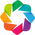

:Layout
   .Image.HitHist               :Image   [x,y]   (z)
   .Image.U_hyphen_minus_Matrix :Image   [x,y]   (z)
   .Image.SDH                   :Image   [x,y]   (z)

In [4]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

hithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) 
um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   

hv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), 
           um.relabel('U-Matrix').opts(cmap='jet'), sdh.relabel('SDH').opts(cmap='viridis')])

In [6]:
from minisom import *

class AlignedSomLayer(MiniSom):
    def __init__(self, n, i, featuresA, x, y, input_len, sigma=1.0, learning_rate=0.5,
                 decay_function=asymptotic_decay,
                 neighborhood_function='gaussian', topology='rectangular',
                 activation_distance='euclidean', random_seed=42):
        super().__init__(x, y, input_len, sigma, learning_rate, decay_function, neighborhood_function, topology, activation_distance, random_seed)
        self.n = n
        self.i = i
        self.featuresA = featuresA
        
        self.underyling_activation_function = self._activation_distance
        self._activation_distance = self.activation_scale_wrapper
        
        #self.rescale(featuresA, n, i)

    def activation_scale_wrapper(self, x, w):
        print(x)
        n = self.n
        i = self.i
        scaleA = (n-i-1)/(n-1)
        scaleB = i/(n-1)

        factor = []
        for j in range(self._input_len):
            if j in self.featuresA:
                factor.append(scaleA)
            else:
                factor.append(scaleB)
        
        xcopy = x.copy()
        wcopy = w.copy()

        print(f"layer {i}")
        print("old")
        print(xcopy)
        print(wcopy)

        xcopy *= array(factor)
        wcopy *= array(factor)


        print("new")
        print(xcopy)
        print(wcopy)

        return self.underyling_activation_function(xcopy, wcopy)



    def rescale(self, featuresA, n, i):
        scaleA = (n-i-1)/(n-1)
        scaleB = i/(n-1)

        factor = []
        for i in range(self._input_len):
            if i in featuresA:
                factor.append(scaleA)
            else:
                factor.append(scaleB)

        self._weights *= factor


    def update_scaled(self, x, win, t, max_iteration, scaling_factor):
        """
        Updates the weights of the neurons. Scaled by the scaling Factor.
        In practice, this factor can be something like 1 / how far the layer is from the "pivot" layer

        Parameters
        ----------
        x : np.array
            Current pattern to learn.
        win : tuple
            Position of the winning neuron for x (array or tuple).
        t : int
            rate of decay for sigma and learning rate
        max_iteration : int
            If use_epochs is True:
                Number of epochs the SOM will be trained for
            If use_epochs is False:
                Maximum number of iterations (one iteration per sample).
        scaling_factor: float
            factor the update is scaled by
        """
        eta = self._decay_function(self._learning_rate, t, max_iteration)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, t, max_iteration)
        # improves the performances
        g = self.neighborhood(win, sig)*eta*scaling_factor
        # w_new = eta * neighborhood_function * (x-w)
        self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


class AlignedSom:
    def __init__(self, n, featuresA, x, y, input_len, sigma=1.0, learning_rate=0.5,
                 decay_function=asymptotic_decay,
                 neighborhood_function='gaussian', topology='rectangular',
                 activation_distance='euclidean', random_seed=42):
        """
        initializes the Aligned Som class.
        n guides how many maps are generated
        featuresA sets which features are in the A set (The rest is in B)

        All the other params get handed over to the "children soms"
        """
        self.n = n
        self.featuresA = featuresA
        self.x = x
        self.y = y
        self._random_seed = random_seed

        self._learning_rate = learning_rate
        self._sigma = sigma
        self._input_len = input_len

        self.topology = topology

        self._decay_function = decay_function
        
        self._random_generator = random.RandomState(random_seed)

        self._layers = [AlignedSomLayer(n, i, featuresA, x, y, input_len, sigma, learning_rate, decay_function, 
                                        neighborhood_function, topology, activation_distance, 
                                        random_seed) for i in range(n)]

    def get_scaled_vector(self, x, i):
        scaleA = (self.n - 1 - i)/(self.n-1)
        scaleB = i/(self.n-1)

        xnew = x.copy()
        
        for j in range(len(x)):
            if j in self.featuresA:
                xnew[j] *= scaleA
            else:
                xnew[j] *= scaleB
        
        return xnew

    def train(self, data, num_iteration):
        """
        Trains the SOM.

        Parameters
        ----------
        data : np.array or list
            Data matrix.

        num_iteration : int
            If use_epochs is False, the weights will be
            updated num_iteration times. Otherwise they will be updated
            len(data)*num_iteration times.
        """

        iterations = build_iteration_indexes(len(data), num_iteration,
                                              False, None,
                                              False)
        def get_decay_rate(iteration_index, data_len):
            return int(iteration_index)

        for t, iteration in enumerate(iterations):
            layer = self._random_generator.randint(low=0, high=self.n)

            pivot = data[iteration]

            winner = self._layers[layer].winner(pivot)

            
            decay_rate = get_decay_rate(t, len(data))

            for update_layer in range(self.n):
                diff = layer - update_layer
                if diff < 0:
                    diff = -diff
                
                scaling_factor = 1/(1+diff)
                self._layers[update_layer].update_scaled(data[iteration], winner,
                        decay_rate, num_iteration, scaling_factor)

    


In [7]:
alignedSom = AlignedSom(11, [0, 1, 2], 2, 2, 10)

data = [[1]*10,[2]*10]
alignedSom.train(data, 10)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
layer 6
old
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[[-0.13210002  0.47456898  0.24427254  0.10388012 -0.36218705
   -0.36221244 -0.46530542  0.38555652  0.10646666  0.21908511]
  [-0.49645318  0.48660971  0.34425713 -0.29788391 -0.32948248
   -0.3278468  -0.20271468  0.02563624 -0.07047355 -0.21619025]]

 [[ 0.14544268 -0.46876729 -0.27027498 -0.17377012 -0.05712234
    0.37081521 -0.39051514  0.01850909  0.12016696 -0.58975198]
  [ 0.10444262 -0.31997183 -0.42240191  0.43593701  0.45220044
    0.29950134 -0.18975013 -0.39072236  0.17891865 -0.05812115]]]
new
[0.4 0.4 0.4 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
[[[-0.05284001  0.18982759  0.09770902  0.06232807 -0.21731223
   -0.21732747 -0.27918325  0.23133391  0.06388     0.13145106]
  [-0.19858127  0.19464389  0.13770285 -0.17873034 -0.19768949
   -0.19670808 -0.12162881  0.01538174 -0.04228413 -0.12971415]]

 [[ 0.05817707 -0.18750691 -0.10810999 -0.10426207 -0.0342734
    0.22248913 -0.23430908  0.01110545  0.07210018